In [241]:
import warnings
warnings.filterwarnings('ignore')

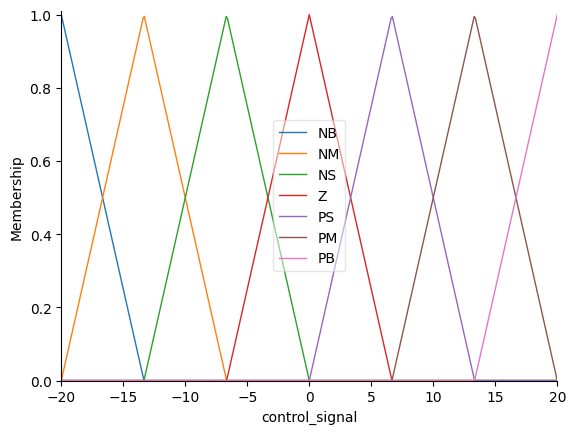

In [242]:
import numpy as np
from skfuzzy import control as ctrl
import skfuzzy as fuzz
# Define the input and output variables.

max_speed = 20

error = ctrl.Antecedent(np.arange(-max_speed*2, max_speed*2 + 0.1, 0.1), "error")
derivative_of_error = ctrl.Antecedent(np.arange(-40, 40.1, 0.1), "derivada_error")
control_signal = ctrl.Consequent(np.arange(-max_speed, max_speed + 0.1, 0.1), "control_signal")

# Auto-membership function population is possible with .automf(3, 5, or 7)
antcds = ['NB', 'NM', 'NS', 'Z', 'PS', 'PM', 'PB']
error.automf(7, names=antcds)
derivative_of_error.automf(7, names=antcds)
control_signal.automf(7, names=antcds)

control_signal.view()

In [243]:
# Create the fuzzy rules.
# Antecedent terms serving as inputs to this rule.
# Multiple terms may be combined using operators | (OR), & (AND), ~ (NOT), and parentheticals to group terms.
rules = []
cnsq=[['NB', 'NB', 'NB', 'NB', 'NM', 'NS', 'Z'],
     ['NB', 'NB', 'NM', 'NM', 'NS', 'Z', 'PS'],
     ['NB', 'NM', 'NS', 'NS', 'Z', 'PS', 'PM'],
     ['NM', 'NM', 'NS', 'Z', 'PS', 'PM', 'PM'],
     ['NM', 'NS', 'Z', 'PS', 'PS', 'PM', 'PB'],
     ['NS', 'Z', 'PS', 'PM', 'PM', 'PB', 'PB'],
     ['Z', 'PS', 'PM', 'PB', 'PB', 'PB', 'PB']]

for index_e, r_e in enumerate(antcds): # por cada antecedente en error
    for index_de, r_de in enumerate(antcds): # por cada antecedente en derivada error
        rules.append(ctrl.Rule(error[r_e] & derivative_of_error[r_de], control_signal[cnsq[index_e][index_de]]))

rules

[IF error[NB] AND derivada_error[NB] THEN control_signal[NB]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[NM] THEN control_signal[NB]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[NS] THEN control_signal[NB]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[Z] THEN control_signal[NB]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[PS] THEN control_signal[NM]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[PM] THEN control_signal[NS]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[PB] THEN control_signal[Z]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NM] AND derivada_error[NB] THEN control_signal[NB]
 	AND aggregation function : fm

Ahora creamos el bloque de inferencia

In [244]:
# Create the inference block of the fuzzy controller.
fuzzy_controller = ctrl.ControlSystem(rules)
flc = ctrl.ControlSystemSimulation(fuzzy_controller) # The whole Fuzzy Inference system

4.600815969875082


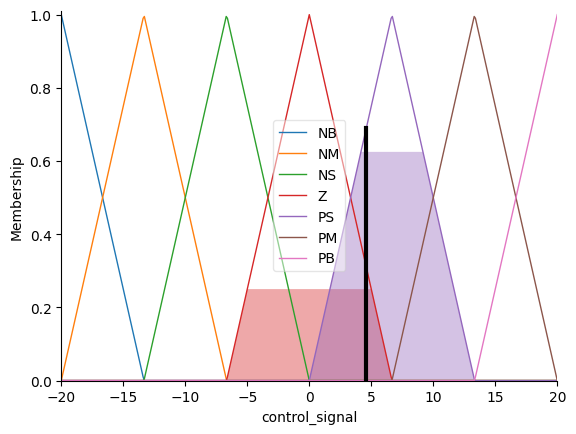

In [245]:
# Calculate the control signal
flc.inputs({'error': 10, 'derivada_error': 5})
flc.compute()

# Print the control signal
print(flc.output['control_signal'])
control_signal.view(sim=flc)

### The Benchmark

Speed:  0.1
RMSE: 0.0185511936162433


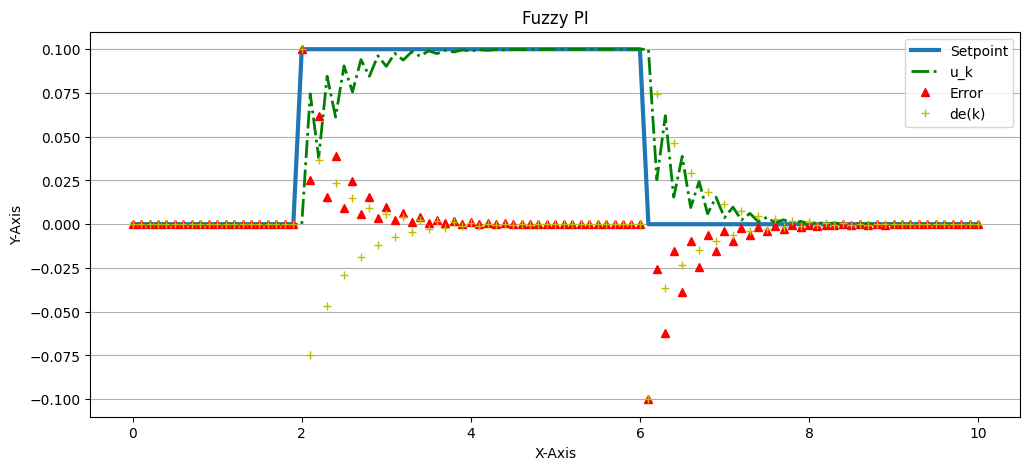

Speed:  1
RMSE: 0.18005549847748195


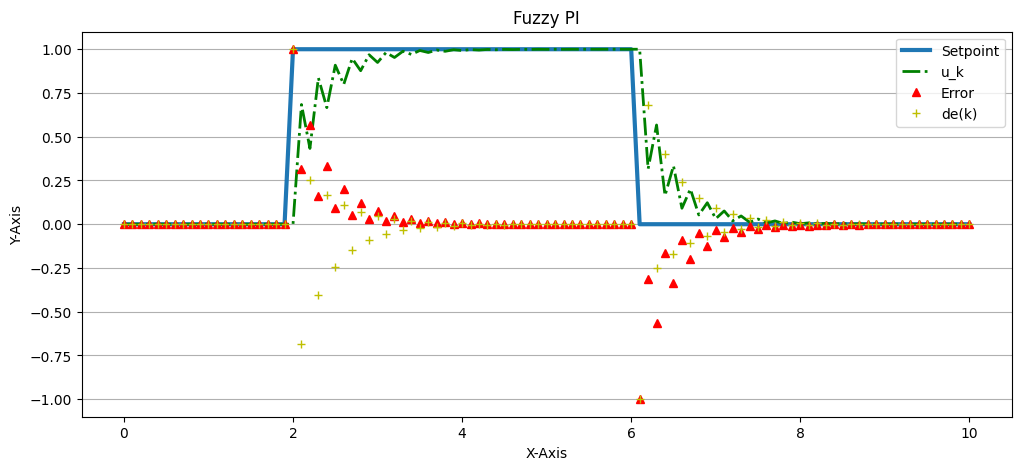

Speed:  10
RMSE: 1.8354895109740226


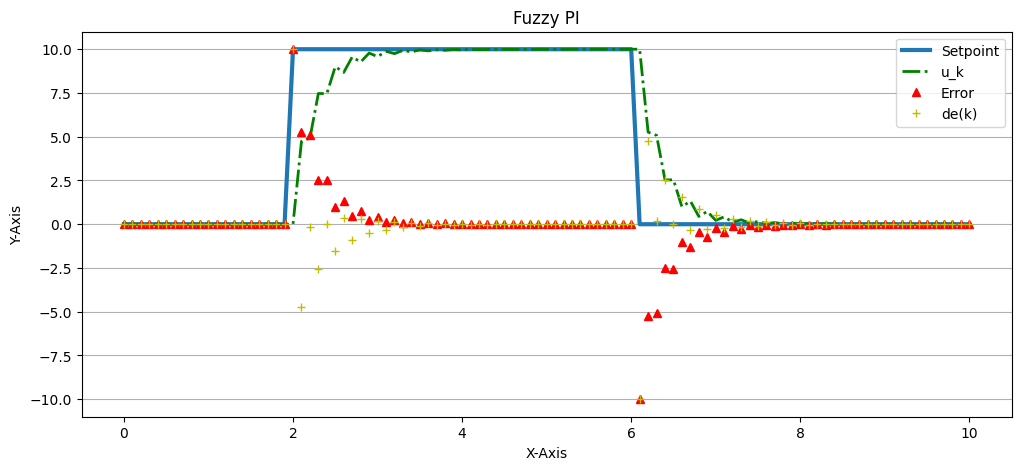

Speed:  20
RMSE: 3.59199103179563


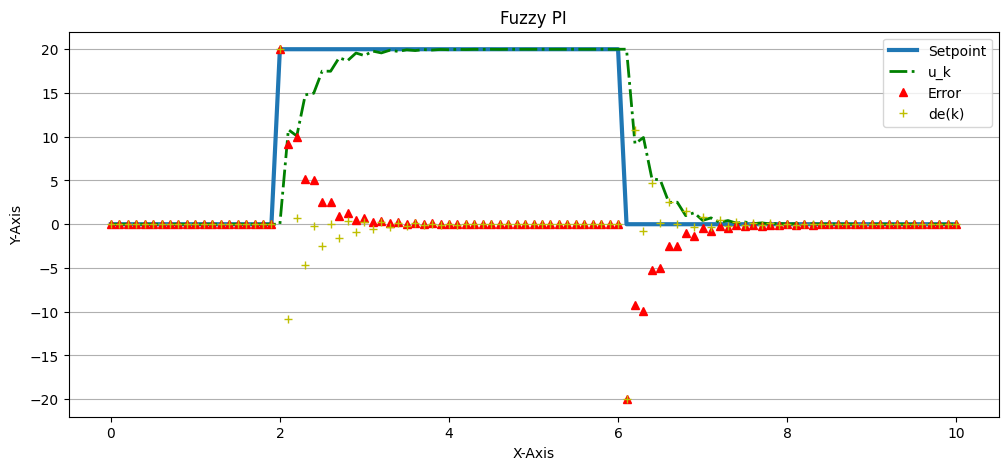

In [246]:
import matplotlib.pyplot as plt


def get_RMSE(real_values_list, predicted_value_list):
    return np.sqrt((np.square(np.subtract(real_values_list, predicted_value_list)).mean()))

xs = np.arange(0, 10.1, 0.1)

for speed in [0.1, 1, 10, 20]:
  # Define the X and Y values
  stepfx = lambda x: speed if x>=2.0 and x<=6.0 else 0
  ys = [stepfx(xi) for xi in xs]

  # accion, error, tasa de cambio del error, error previo
  u_k, e_k, de_k, prev_e_k = 0.0, 0.0, 0.0, 0.0
  y_preds, errors, de, du = [], [], [], []
  for xi in xs:
    ref = stepfx(xi)  # reference
    flc.inputs({'error': e_k, 'derivada_error': de_k})
    flc.compute()
    # Retrieve the output of the FLC component
    du_k = flc.output['control_signal']
    u_k = u_k + du_k  # take the feedback into account for new output
    e_k = ref - u_k  # current error
    de_k = e_k - prev_e_k  # rate of change of error
    prev_e_k = e_k  # update previous e_k

    y_preds.append(u_k)
    errors.append(e_k)
    de.append(de_k)
    du.append(du_k)

  rmse = get_RMSE(ys, y_preds)
  print("Speed: ", speed)
  print('RMSE:', rmse)
  
  plt.figure(figsize=(12, 5))
  plt.gca().yaxis.grid(True)
  plt.plot(xs, ys, linewidth=3, label='Setpoint')
  plt.plot(xs, y_preds, 'g-.', linewidth=2, label='u_k')  # Fuzzy PI
  plt.plot(xs, errors, 'r^', label='Error')
  plt.plot(xs, de, 'y+', label='de(k)')

  plt.title("Fuzzy PI")
  plt.xlabel("X-Axis")
  plt.ylabel("Y-Axis")
  plt.legend()
  # Show the plot
  plt.show()


